In [1]:
# !pip install spacy
# ! pip install evaluate

In [1]:
import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

import spacy
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

import optuna
from tqdm import tqdm

import evaluate # type: ignore
squad_metric = evaluate.load("squad")


C:\Users\toanc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\toanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\toanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [3]:
# !python -m spacy download en_core_web_sm

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
def load_and_split_data():
    squad = load_dataset("squad")

    # print("One data sample:")
    # import json
    # example = squad['train'][1000]
    # print(json.dumps(example, indent=2, ensure_ascii=False))

    # Load train/val dataset
    # train_data = squad['train'].select(range(100))
    # test_ds = squad['validation'].select(range(100))  # test set

    train_data = squad['train']
    test_ds = squad['validation']   # test set

    # Split training data into train and val
    train_ds, val_ds = train_test_split(train_data.to_list(), test_size=0.1, random_state=42)

    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = load_and_split_data()

In [7]:
# context_lengths = [len(word_tokenize(example["context"])) for example in train_ds]
# context_lengths_series = pd.Series(context_lengths)
# print("\nContext Length stats - training data:")
# print(context_lengths_series.describe(percentiles=[.5, .9, .95, .99]))

In [8]:
GLOVE_PATH = "glove.6B.300d.txt"
EMBEDDING_DIM = 300

In [9]:
def load_glove_embeddings(glove_path=GLOVE_PATH, embedding_dim=EMBEDDING_DIM):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

In [10]:

def build_vocab_and_matrix(tokenized_texts, glove_embeddings, embedding_dim=EMBEDDING_DIM):
    vocab = {'<pad>': 0, '<unk>': 1}
    vectors = [np.zeros(embedding_dim), np.random.normal(scale=0.6, size=(embedding_dim,))]

    idx = 2
    for tokens in tokenized_texts:
        for token in tokens:
            if token not in vocab and token in glove_embeddings:
                vocab[token] = idx
                vectors.append(glove_embeddings[token])
                idx += 1
    embedding_matrix = np.array(vectors)
    return vocab, embedding_matrix

In [11]:
def qa_collate_fn(batch):
    context_ids = [item['context_ids'] for item in batch]
    question_ids = [item['question_ids'] for item in batch]
    start_positions = torch.tensor([item['start'] for item in batch], dtype=torch.long)
    end_positions = torch.tensor([item['end'] for item in batch], dtype=torch.long)

    # Pad context and question sequences to the longest in batch
    context_ids_padded = pad_sequence(context_ids, batch_first=True, padding_value=0)
    question_ids_padded = pad_sequence(question_ids, batch_first=True, padding_value=0)

    return {
        'context_ids': context_ids_padded,
        'question_ids': question_ids_padded,
        'start': start_positions,
        'end': end_positions
    }

In [12]:
def preprocess_squad(dataset_split, vocab, max_context_len=300, max_question_len=30):
    contexts, questions, start_positions, end_positions, raw_examples = [], [], [], [], []
    skipped = 0
    for example in dataset_split:
        context_text = example['context']
        question_text = example['question']
        answer_text = example['answers']['text'][0]
        answer_start = example['answers']['answer_start'][0]

        # Tokenize
        context_tokens = word_tokenize(context_text.lower())
        question_tokens = word_tokenize(question_text.lower())

        # Map token spans to character spans
        char_to_token = []
        char_idx = 0
        for token in context_tokens:
            while char_idx < len(context_text) and context_text[char_idx].isspace():
                char_idx += 1
            start = char_idx
            end = start + len(token)
            char_to_token.append((start, end))
            char_idx = end

        # Find token-level start and end indices of answer
        answer_end = answer_start + len(answer_text)
        start_idx, end_idx = None, None
        for i, (s, e) in enumerate(char_to_token):
            if start_idx is None and s <= answer_start < e:
                start_idx = i
            if s < answer_end <= e:
                end_idx = i
                break

        # Skip example if answer span is not found or gets truncated
        if start_idx is None or end_idx is None or end_idx >= max_context_len:
            skipped += 1
            continue

        # Truncate and convert to indices
        context_tokens = context_tokens[:max_context_len]
        question_tokens = question_tokens[:max_question_len]
        context_ids = [vocab.get(tok, vocab['<unk>']) for tok in context_tokens]
        question_ids = [vocab.get(tok, vocab['<unk>']) for tok in question_tokens]

        # Append valid sample
        contexts.append(context_ids)
        questions.append(question_ids)
        start_positions.append(start_idx)
        end_positions.append(end_idx)
        raw_examples.append(example)
    
    print(f"Skipped {skipped} out of {len(dataset_split)} examples")

    return contexts, questions, start_positions, end_positions, raw_examples


In [13]:
class SquadDataset(Dataset):
    def __init__(self, contexts, questions, starts, ends, pad_idx=0):
        self.contexts = contexts
        self.questions = questions
        self.starts = starts
        self.ends = ends
        self.pad_idx = pad_idx

    def __len__(self):
        return len(self.contexts)

    def __getitem__(self, idx):
        return {
            'context_ids': torch.tensor(self.contexts[idx], dtype=torch.long),
            'question_ids': torch.tensor(self.questions[idx], dtype=torch.long),
            'start': torch.tensor(self.starts[idx], dtype=torch.long),
            'end': torch.tensor(self.ends[idx], dtype=torch.long)
        }

In [14]:
def load_and_process_data():
    # Tokenize for building vocab (from train only)
    tokenized_train_texts = [
        word_tokenize(x['context'].lower()) + word_tokenize(x['question'].lower())
        for x in train_ds
    ]
    glove = load_glove_embeddings(GLOVE_PATH)
    vocab, embedding_matrix = build_vocab_and_matrix(tokenized_train_texts, glove)
    
    with open('vocab.json', 'w') as f:
        json.dump(vocab, f)

    # Preprocess train/val/test split   s
    train_ctx, train_qs, train_start, train_end, train_raw = preprocess_squad(train_ds, vocab)
    val_ctx, val_qs, val_start, val_end, val_raw = preprocess_squad(val_ds, vocab)
    test_ctx, test_qs, test_start, test_end, test_raw = preprocess_squad(test_ds, vocab)

    print(f"Train data: context={len(train_ctx)}, question={len(train_qs)}, spans={len(train_start)}")
    print(f"Val data:   context={len(val_ctx)}, question={len(val_qs)}, spans={len(val_start)}")
    print(f"Test data:  context={len(test_ctx)}, question={len(test_qs)}, spans={len(test_start)}")
    print(f"Embedding_matrix shape: {embedding_matrix.shape}")

    # print("\nOne preprocessed sample:")
    # print("Context token IDs:", train_ctx[1000])
    # print("Question token IDs:", train_qs[1000])
    # print("Start token index:", train_start[1000])
    # print("End token index:", train_end[1000])
    # print("Answer span tokens:", train_ctx[1000][train_start[1000]:train_end[1000]+1])

    # Create datasets
    train_dataset = SquadDataset(train_ctx, train_qs, train_start, train_end)
    val_dataset = SquadDataset(val_ctx, val_qs, val_start, val_end)
    test_dataset = SquadDataset(test_ctx, test_qs, test_start, test_end)

    return train_dataset, val_dataset, test_dataset, embedding_matrix, train_raw, val_raw, test_raw


In [15]:
train_dataset, val_dataset, test_dataset, embedding_matrix, train_raw, val_raw, test_raw = load_and_process_data()

Skipped 120 out of 78839 examples
Skipped 14 out of 8760 examples
Skipped 40 out of 10570 examples
Train data: context=78719, question=78719, spans=78719
Val data:   context=8746, question=8746, spans=8746
Test data:  context=10530, question=10530, spans=10530
Embedding_matrix shape: (73152, 300)


In [16]:
class BiLSTM_QA(nn.Module):
    def __init__(self, embedding_matrix, hidden_size=128, dropout=0.3, use_attention=False):
        super(BiLSTM_QA, self).__init__()
        self.use_attention = use_attention
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))

        # output: [B, seq_len, 2*hidden_size]
        self.context_lstm = nn.LSTM(embedding_matrix.shape[1], hidden_size, bidirectional=True, batch_first=True)
        self.question_lstm = nn.LSTM(embedding_matrix.shape[1], hidden_size, bidirectional=True, batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        self.attention_output_size = hidden_size * 8 if use_attention else hidden_size * 4
        self.modeling_lstm_1 = nn.LSTM(self.attention_output_size, hidden_size, bidirectional=True, batch_first=True)
        self.modeling_lstm_2 = nn.LSTM(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        # In BiDAF attention, compute a similarity score S[i][j] between each context and question word, based on concatenation
        if use_attention:
            self.similarity_linear = nn.Linear(hidden_size * 6, 1)

        self.start_fc = nn.Linear(hidden_size * 2, 1)  # [context; question]
        self.end_fc = nn.Linear(hidden_size * 2, 1)
    
    def bidaf_attention(self, context_out, question_out):
        """
        BiDAF-style attention:
        context_out: [B, C_len, 2H]
        question_out: [B, Q_len, 2H]
        Returns: [B, C_len, 8H]
        """
        B, C_len, H2 = context_out.size()
        Q_len = question_out.size(1)

        # Expand for pairwise interaction
        c_expand = context_out.unsqueeze(2).expand(B, C_len, Q_len, H2)
        q_expand = question_out.unsqueeze(1).expand(B, C_len, Q_len, H2)
        elementwise_product = c_expand * q_expand

        # Similarity matrix S
        concat_sim = torch.cat([c_expand, q_expand, elementwise_product], dim=-1)  # [B, C_len, Q_len, 6H]
        S = self.similarity_linear(concat_sim).squeeze(-1)  # [B, C_len, Q_len]

        # Context-to-question attention (C2Q)
        a = torch.softmax(S, dim=-1)  # [B, C_len, Q_len]
        c2q = torch.bmm(a, question_out)  # [B, C_len, 2H]

        # Question-to-context attention (Q2C)
        b = torch.softmax(S.max(dim=-1).values, dim=-1)  # [B, C_len]
        q2c = torch.bmm(b.unsqueeze(1), context_out).repeat(1, C_len, 1)  # [B, C_len, 2H]

        # Final fusion: [c; c2q; c * c2q; c * q2c]
        combined = torch.cat([
            context_out,
            c2q,
            context_out * c2q,
            context_out * q2c
        ], dim=-1)  # [B, C_len, 8H]

        return combined

    def forward(self, context_ids, question_ids):
        context_embed = self.embedding(context_ids)         # [batch_size, context_len, embedding_dim]
        question_embed = self.embedding(question_ids)       # [batch_size, question_len, embedding_dim]

        context_out, _ = self.context_lstm(context_embed)   # [batch_size, context_len, 2*hidden_size]
        question_out, _ = self.question_lstm(question_embed)# [batch_size, question_len, 2*hidden_size]
        
        context_out = self.dropout(context_out)
        question_out = self.dropout(question_out)

        if self.use_attention:
            # Attention from question to context and from context to question (BiDAF)
            combined = self.bidaf_attention(context_out, question_out)
        else:
            # Average pooled question representation
            question_vector = torch.mean(question_out, dim=1)  # [B, 2H]
            question_vector = question_vector.unsqueeze(1).expand(-1, context_out.size(1), -1)  # [B, C_len, 2H]
            combined = torch.cat([context_out, question_vector], dim=-1)  # [B, C_len, 4H]
        
        combined = self.dropout(combined)

        modeled_out_1, _ = self.modeling_lstm_1(combined)  # [B, C_len, 2H]
        modeled_out_2, _ = self.modeling_lstm_2(modeled_out_1)
        modeled_out = modeled_out_2 + modeled_out_1
        modeled_out = self.layer_norm(modeled_out)

        start_logits = self.start_fc(modeled_out).squeeze(-1)
        end_logits = self.end_fc(modeled_out).squeeze(-1)

        return start_logits, end_logits

In [17]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct_start = 0
    correct_end = 0
    total = 0

    for batch in tqdm(dataloader, desc="Training"):
        context_ids = batch['context_ids'].to(device)
        question_ids = batch['question_ids'].to(device)
        start_pos = batch['start'].to(device)
        end_pos = batch['end'].to(device)

        optimizer.zero_grad()
        start_logits, end_logits = model(context_ids, question_ids)

        loss_start = criterion(start_logits, start_pos)
        loss_end = criterion(end_logits, end_pos)
        loss = (loss_start + loss_end) / 2
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy
        pred_start = torch.argmax(start_logits, dim=1)
        pred_end = torch.argmax(end_logits, dim=1)
        correct_start += (pred_start == start_pos).sum().item()
        correct_end += (pred_end == end_pos).sum().item()
        total += context_ids.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = (correct_start + correct_end) / (2 * total)  # average over start and end
    return avg_loss, avg_accuracy


In [18]:
def predict_spans(model, dataloader, raw_dataset, device):
    model.eval()
    predictions = []

    idx = 0
    max_answer_len = 15

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting spans"):
            # Move input tensors to GPU or CPU
            context_ids = batch['context_ids'].to(device)
            question_ids = batch['question_ids'].to(device)

            # Run model
            start_logits, end_logits = model(context_ids, question_ids)

            # Loop over batch items
            for i in range(context_ids.size(0)):
                # Move logits to CPU before processing
                start_logit = start_logits[i].to("cpu")
                end_logit = end_logits[i].to("cpu")

                # Find best span
                max_score = -float("inf")
                best_start, best_end = 0, 0
                for start_idx in range(len(start_logit)):
                    for end_idx in range(start_idx, min(start_idx + max_answer_len, len(end_logit))):
                        score = start_logit[start_idx] + end_logit[end_idx]
                        if score > max_score:
                            best_start, best_end = start_idx, end_idx
                            max_score = score

                # Reconstruct predicted answer text
                example = raw_dataset[idx]
                context_tokens = word_tokenize(example["context"].lower())

                pred_tokens = context_tokens[best_start:best_end + 1] if best_end < len(context_tokens) else []
                prediction_text = " ".join(pred_tokens)

                predictions.append({
                    "id": example["id"],
                    "prediction_text": prediction_text
                })
                idx += 1

    return predictions

def get_references(raw_dataset):
    return [{"id": ex["id"], "answers": ex["answers"]} for ex in raw_dataset]


In [19]:
def evaluate(model, dataloader, raw_dataset, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_start = 0
    correct_end = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            context_ids = batch['context_ids'].to(device)
            question_ids = batch['question_ids'].to(device)
            start_pos = batch['start'].to(device)
            end_pos = batch['end'].to(device)

            start_logits, end_logits = model(context_ids, question_ids)

            loss_start = criterion(start_logits, start_pos)
            loss_end = criterion(end_logits, end_pos)
            loss = (loss_start + loss_end) / 2
            total_loss += loss.item()

            pred_start = torch.argmax(start_logits, dim=1)
            pred_end = torch.argmax(end_logits, dim=1)
            correct_start += (pred_start == start_pos).sum().item()
            correct_end += (pred_end == end_pos).sum().item()
            total += context_ids.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = (correct_start + correct_end) / (2 * total)

    predictions = predict_spans(model, dataloader, raw_dataset, device)
    references = get_references(raw_dataset)
    scores = squad_metric.compute(predictions=predictions, references=references)
    val_em = scores["exact_match"]
    val_f1 = scores["f1"]

    return val_f1, val_em, avg_loss, avg_accuracy


In [20]:
comparison_df = pd.DataFrame(columns=[
    'model_name',
    'best_hyperparameters',
    'val_loss',
    'val_exact_match',
    'val_f1',
    'training_time'
])

In [21]:
def objective(trial, use_attention):
    # Suggest hyperparams
    hidden_size = trial.suggest_categorical("hidden_size", [128, 256])
    lr = trial.suggest_float("lr", 5e-5, 5e-4, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.4)
    batch_size = trial.suggest_categorical("batch_size", [16, 32])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Model
    model = BiLSTM_QA(embedding_matrix, hidden_size=hidden_size, dropout=dropout, use_attention=use_attention).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=qa_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=qa_collate_fn)


    # Training loop
    history = {
        'train_loss': [], 'val_loss': [],
        'train_accuracy': [], 'val_accuracy': [],
        'val_f1': [], 'val_em': [],
    }
    best_model_state = None
    best_val_loss = float("inf")
    early_stop_count = 0
    patience = 5
    start_time = time.time()

    for epoch in range(20):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_f1, val_em, val_loss, val_acc = evaluate(model, val_loader, val_raw, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_em'].append(val_em)

        trial.report(val_f1, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stop_count = 0
        else:
            early_stop_count += 1
            if early_stop_count >= patience:
                break

    total_time = round(time.time() - start_time, 2)
    trial.set_user_attr("history", history)
    trial.set_user_attr("training_time", total_time)
    trial.set_user_attr("val_loss", val_loss)
    trial.set_user_attr("val_em", val_em)
    trial.set_user_attr("best_model_state_dict", best_model_state)

    return val_f1


In [22]:
def run_optuna(use_attention, n_trials=8, model_name="Plain LSTMs"):
    study = optuna.create_study(direction="maximize")

    with tqdm(total=n_trials, desc="Training", unit="trial") as pbar:
        def callback(study, trial):
            pbar.update(1)
            print(
                f"Trial {trial.number} finished - "
                f"F1: {trial.value:.2f}")

        study.optimize(lambda trial: objective(trial, use_attention), n_trials=n_trials, callbacks=[callback])

    best_trial = study.best_trial
    print(f"Best trial (trial {best_trial.number}) hyperparameters: {best_trial.params}")

    from pathlib import Path
    model_path = f"saved_models_300d/{model_name.replace(' ', '_')}_best_model.pt"
    Path("saved_models_300d").mkdir(exist_ok=True)
    torch.save(best_trial.user_attrs["best_model_state_dict"], model_path)
    print(f"Best model saved to: {model_path}")

    # Retrieve training history.
    history = best_trial.user_attrs["history"]

    global comparison_df
    comparison_df.loc[len(comparison_df)] = {
        'model_name': model_name,
        'best_hyperparameters': best_trial.params,
        'val_loss': best_trial.user_attrs["val_loss"],
        'val_exact_match': best_trial.user_attrs.get("val_em"),
        'val_f1': best_trial.value,
        'training_time': best_trial.user_attrs["training_time"]
    }

    return best_trial, history


In [23]:
def summarize_diagnostics(history, model_name, folder_path="plots_300d/"):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f"Training Diagnostics for {model_name}", fontsize=24, fontweight='bold')
    epochs = list(range(len(history['train_loss'])))
    
    # Plot loss curves
    ax[0].set_title('Loss Curves', fontsize=20)
    ax[0].plot(history['train_loss'], label='train')
    ax[0].plot(history['val_loss'], label='validation')
    ax[0].set_xticks(epochs)
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Loss', fontsize=15)
    ax[0].legend(fontsize=15)
    # Plot accuracy curves
    ax[1].set_title('Accuracy Curves', fontsize=20)
    ax[1].plot(history['train_accuracy'], label='train')
    ax[1].plot(history['val_accuracy'], label='validation')
    ax[1].set_xticks(epochs)
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('Accuracy', fontsize=15)
    ax[1].legend(fontsize=15)

    plot_filename = os.path.join(folder_path, f"{model_name}_loss_accuracy.png")
    plt.savefig(plot_filename)
    print(f"Plot saved to {plot_filename}")

    plt.show()
    plt.close(fig)

In [ ]:
# Run Optuna for model w/o attention
best_trial_plain, history_plain = run_optuna(use_attention=False, model_name="Plain LSTMs")

[I 2025-04-24 18:04:32,311] A new study created in memory with name: no-name-472b6872-7d89-4ec9-97d8-846d5931fead
Predicting spans: 100%|██████████| 274/274 [03:38<00:00,  1.25it/s]
[I 2025-04-24 19:49:09,401] Trial 0 finished with value: 47.067081203157954 and parameters: {'hidden_size': 256, 'lr': 0.00010014104955513628, 'dropout': 0.3909809036740618, 'batch_size': 32, 'weight_decay': 1.130425805908037e-06}. Best is trial 0 with value: 47.067081203157954.
Training:  12%|█▎        | 1/8 [1:44:37<12:12:19, 6277.09s/trial]

Trial 0 finished - F1: 47.07


Predicting spans: 100%|██████████| 274/274 [03:40<00:00,  1.24it/s]
[I 2025-04-24 21:20:08,507] Trial 1 finished with value: 43.904672190233676 and parameters: {'hidden_size': 128, 'lr': 6.55311607690762e-05, 'dropout': 0.12161153238024576, 'batch_size': 32, 'weight_decay': 6.6729088423655e-06}. Best is trial 0 with value: 47.067081203157954.
Training:  25%|██▌       | 2/8 [3:15:36<9:39:35, 5795.92s/trial] 

Trial 1 finished - F1: 43.90


Predicting spans: 100%|██████████| 547/547 [03:42<00:00,  2.46it/s]
[I 2025-04-24 23:26:08,315] Trial 2 finished with value: 46.01499417284625 and parameters: {'hidden_size': 256, 'lr': 5.348430929356866e-05, 'dropout': 0.1396283424492747, 'batch_size': 16, 'weight_decay': 8.800153325936738e-05}. Best is trial 0 with value: 47.067081203157954.
Training:  38%|███▊      | 3/8 [5:21:36<9:10:06, 6601.35s/trial]

Trial 2 finished - F1: 46.01


Predicting spans: 100%|██████████| 274/274 [03:41<00:00,  1.24it/s]
[I 2025-04-25 00:29:56,261] Trial 3 finished with value: 46.62524926643606 and parameters: {'hidden_size': 128, 'lr': 0.00016406351000944314, 'dropout': 0.21812165194240712, 'batch_size': 32, 'weight_decay': 4.835257541651435e-06}. Best is trial 0 with value: 47.067081203157954.
Training:  50%|█████     | 4/8 [6:25:23<6:07:05, 5506.44s/trial]

Trial 3 finished - F1: 46.63


Predicting spans: 100%|██████████| 547/547 [03:27<00:00,  2.63it/s]
[I 2025-04-25 01:58:40,997] Trial 4 finished with value: 46.299469100180765 and parameters: {'hidden_size': 128, 'lr': 0.00017098628230429014, 'dropout': 0.26153906005021765, 'batch_size': 16, 'weight_decay': 0.0007685314474065228}. Best is trial 0 with value: 47.067081203157954.
Training:  62%|██████▎   | 5/8 [7:54:08<4:32:02, 5440.92s/trial]

Trial 4 finished - F1: 46.30


Predicting spans: 100%|██████████| 547/547 [03:43<00:00,  2.45it/s]
[I 2025-04-25 03:17:13,597] Trial 5 finished with value: 50.50085534137113 and parameters: {'hidden_size': 256, 'lr': 0.00036133685205630325, 'dropout': 0.2722185960157446, 'batch_size': 16, 'weight_decay': 4.819169213547658e-06}. Best is trial 5 with value: 50.50085534137113.
Training:  75%|███████▌  | 6/8 [9:12:41<2:53:06, 5193.29s/trial]

Trial 5 finished - F1: 50.50


Predicting spans: 100%|██████████| 547/547 [03:45<00:00,  2.43it/s]
[I 2025-04-25 04:12:16,390] Trial 6 pruned. 
Training:  88%|████████▊ | 7/8 [10:07:44<1:16:15, 4575.24s/trial]

Trial 6 finished - F1: 41.74


Predicting spans: 100%|██████████| 547/547 [03:42<00:00,  2.46it/s]
[I 2025-04-25 04:51:41,076] Trial 7 pruned. 
Training: 100%|██████████| 8/8 [10:47:08<00:00, 4853.60s/trial]  

Trial 7 finished - F1: 37.71
Best trial (trial 5) hyperparameters: {'hidden_size': 256, 'lr': 0.00036133685205630325, 'dropout': 0.2722185960157446, 'batch_size': 16, 'weight_decay': 4.819169213547658e-06}
Best model saved to: saved_models/Plain_LSTMs_best_model.pt


In [ ]:
# this used random weights --> not the best trained model
best_params_lstm = best_trial_plain.params
print(best_params_lstm)

best_lstm_model = BiLSTM_QA(
    embedding_matrix=embedding_matrix,
    hidden_size=best_params_lstm["hidden_size"],
    dropout=best_params_lstm["dropout"],
    use_attention=True
).to(device)

{'hidden_size': 256, 'lr': 0.00036133685205630325, 'dropout': 0.2722185960157446, 'batch_size': 16, 'weight_decay': 4.819169213547658e-06}


Plot saved to plots/Plain_LSTMs_loss_accuracy.png


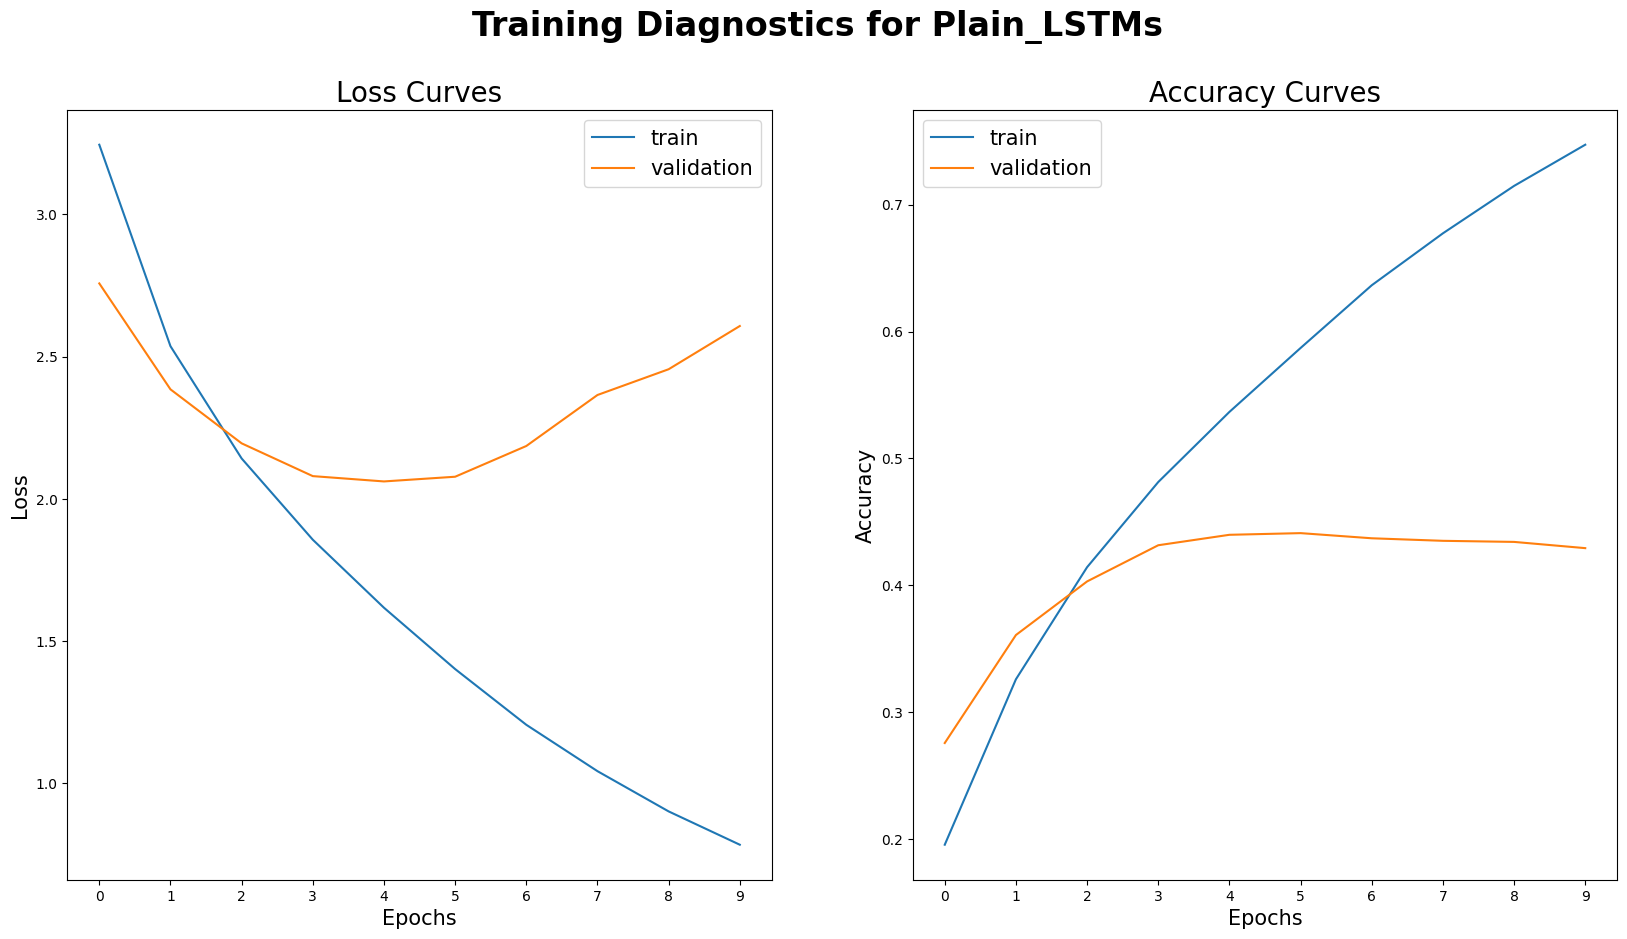

In [37]:
summarize_diagnostics(history_plain, model_name="Plain_LSTMs")

In [38]:
comparison_df

,model_name,best_hyperparameters,val_loss,val_exact_match,val_f1,training_time
0,Plain LSTMs,"{'hidden_size': 256, 'lr': 0.00036133685205630...",2.60727,37.742968,50.500855,4712.45


In [24]:
best_lstm_model = BiLSTM_QA(
    embedding_matrix=embedding_matrix,
    hidden_size=256,
    dropout=0.2722185960157446,
    use_attention=False  # Plain LSTMs
)
best_lstm_model.load_state_dict(torch.load("saved_models_300d/Plain_LSTMs_best_model.pt", map_location=device))
best_lstm_model.to(device)

BiLSTM_QA(
  (embedding): Embedding(73152, 300)
  (context_lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (question_lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2722185960157446, inplace=False)
  (modeling_lstm_1): LSTM(1024, 256, batch_first=True, bidirectional=True)
  (modeling_lstm_2): LSTM(512, 256, batch_first=True, bidirectional=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (start_fc): Linear(in_features=512, out_features=1, bias=True)
  (end_fc): Linear(in_features=512, out_features=1, bias=True)
)

In [31]:
# Run Optuna for model w/ attention
best_trial_attn, history_attn = run_optuna(use_attention=True, model_name="LSTMs + Attention")

[I 2025-04-25 11:26:29,672] A new study created in memory with name: no-name-95d56991-1f23-4a81-9502-312c30804fae
Predicting spans: 100%|██████████| 547/547 [03:43<00:00,  2.45it/s]
[I 2025-04-25 13:54:14,117] Trial 0 finished with value: 56.70905174141675 and parameters: {'hidden_size': 256, 'lr': 9.171294514232545e-05, 'dropout': 0.37066368017596363, 'batch_size': 16, 'weight_decay': 1.3846118559345098e-06}. Best is trial 0 with value: 56.70905174141675.
Training:  12%|█▎        | 1/8 [2:27:44<17:14:11, 8864.44s/trial]

Trial 0 finished - F1: 56.71


Predicting spans: 100%|██████████| 547/547 [03:37<00:00,  2.51it/s]
[I 2025-04-25 17:05:53,831] Trial 1 finished with value: 54.800965813719735 and parameters: {'hidden_size': 128, 'lr': 7.73604279492117e-05, 'dropout': 0.2173394077289431, 'batch_size': 16, 'weight_decay': 1.2915042198057939e-05}. Best is trial 0 with value: 56.70905174141675.
Training:  25%|██▌       | 2/8 [5:39:24<17:21:27, 10414.60s/trial]

Trial 1 finished - F1: 54.80


Predicting spans: 100%|██████████| 547/547 [03:37<00:00,  2.52it/s]
[I 2025-04-25 20:26:34,638] Trial 2 finished with value: 54.89599128078146 and parameters: {'hidden_size': 128, 'lr': 5.75073424593856e-05, 'dropout': 0.3578789531333175, 'batch_size': 16, 'weight_decay': 1.0093445810254733e-06}. Best is trial 0 with value: 56.70905174141675.
Training:  38%|███▊      | 3/8 [9:00:04<15:29:45, 11157.16s/trial]

Trial 2 finished - F1: 54.90


Predicting spans: 100%|██████████| 547/547 [03:33<00:00,  2.56it/s]
[I 2025-04-25 22:06:49,590] Trial 3 finished with value: 66.47776402726555 and parameters: {'hidden_size': 128, 'lr': 0.0004637696096321046, 'dropout': 0.23763159681072626, 'batch_size': 16, 'weight_decay': 1.2342067058189668e-06}. Best is trial 3 with value: 66.47776402726555.
Training:  50%|█████     | 4/8 [10:40:19<10:08:28, 9127.07s/trial]

Trial 3 finished - F1: 66.48


Predicting spans: 100%|██████████| 274/274 [04:17<00:00,  1.06it/s]
[I 2025-04-26 08:08:02,200] Trial 4 finished with value: 52.968999144310764 and parameters: {'hidden_size': 256, 'lr': 5.2776081650932764e-05, 'dropout': 0.14882541792272475, 'batch_size': 32, 'weight_decay': 2.969718834140467e-06}. Best is trial 3 with value: 66.47776402726555.
Training:  62%|██████▎   | 5/8 [20:41:32<15:42:11, 18843.83s/trial]

Trial 4 finished - F1: 52.97


Predicting spans: 100%|██████████| 547/547 [03:38<00:00,  2.51it/s]
[I 2025-04-26 08:18:15,855] Trial 5 pruned. 
Training:  75%|███████▌  | 6/8 [20:51:46<7:01:31, 12645.56s/trial] 

Trial 5 finished - F1: 24.66


Predicting spans: 100%|██████████| 274/274 [03:45<00:00,  1.21it/s]
[I 2025-04-26 08:38:34,028] Trial 6 pruned. 
Training:  88%|████████▊ | 7/8 [21:12:04<2:28:29, 8909.68s/trial] 

Trial 6 finished - F1: 32.48


Predicting spans: 100%|██████████| 547/547 [03:37<00:00,  2.52it/s]
[I 2025-04-26 12:03:09,093] Trial 7 finished with value: 65.36881994579518 and parameters: {'hidden_size': 128, 'lr': 0.00032659662810469766, 'dropout': 0.10779587867438623, 'batch_size': 16, 'weight_decay': 0.0005531894160304365}. Best is trial 3 with value: 66.47776402726555.
Training: 100%|██████████| 8/8 [24:36:39<00:00, 11074.93s/trial] 

Trial 7 finished - F1: 65.37
Best trial (trial 3) hyperparameters: {'hidden_size': 128, 'lr': 0.0004637696096321046, 'dropout': 0.23763159681072626, 'batch_size': 16, 'weight_decay': 1.2342067058189668e-06}
Best model saved to: saved_models/LSTMs_+_Attention_best_model.pt


Plot saved to plots/LSTMs_Attn_loss_accuracy.png


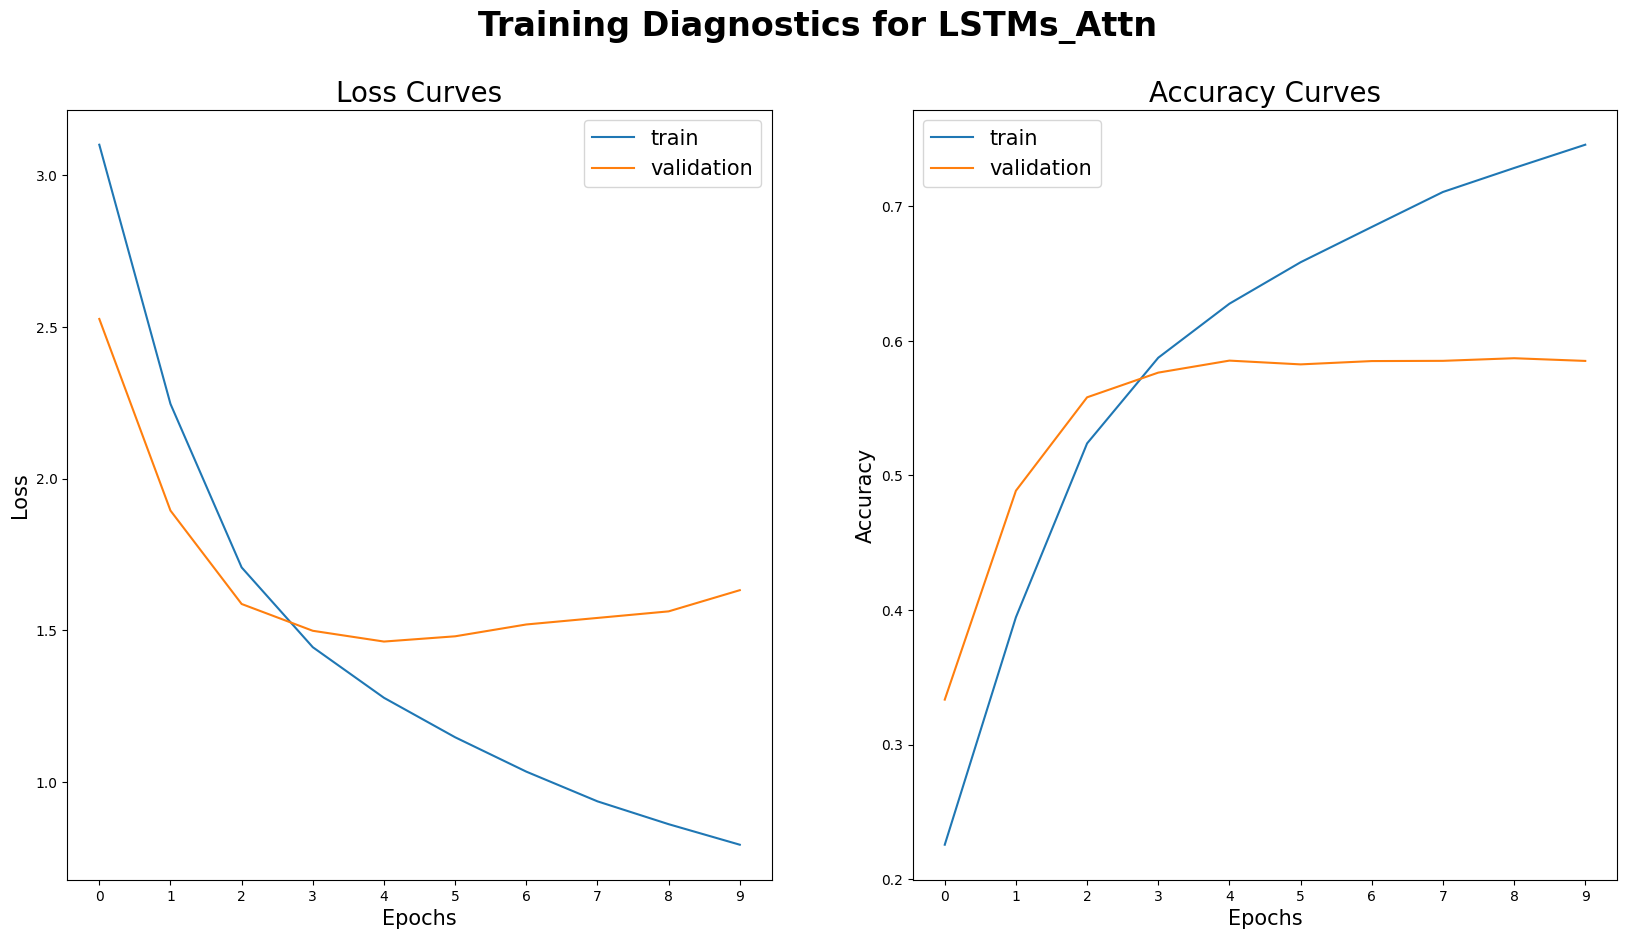

In [33]:
summarize_diagnostics(history_attn, model_name="LSTMs_Attn")

In [26]:
best_lstm_attn_model = BiLSTM_QA(
    embedding_matrix=embedding_matrix,
    hidden_size=128,
    dropout=0.23763159681072626,
    use_attention=True
)
best_lstm_attn_model.load_state_dict(torch.load("saved_models_300d/LSTMs_+_Attention_best_model.pt", map_location=device))
best_lstm_attn_model.to(device)

BiLSTM_QA(
  (embedding): Embedding(73152, 300)
  (context_lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (question_lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.23763159681072626, inplace=False)
  (modeling_lstm_1): LSTM(1024, 128, batch_first=True, bidirectional=True)
  (modeling_lstm_2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (similarity_linear): Linear(in_features=768, out_features=1, bias=True)
  (start_fc): Linear(in_features=256, out_features=1, bias=True)
  (end_fc): Linear(in_features=256, out_features=1, bias=True)
)

# EVALUATE ON TEST SET

In [34]:
def evaluate_on_test(model, model_name, test_loader, test_raw, device):
    global comparison_df
    
    print("\nRunning full evaluation on test set...")
    predicted_answers = predict_spans(model, test_loader, test_raw, device)
    references = get_references(test_raw)

    results = squad_metric.compute(predictions=predicted_answers, references=references)
    em_score = results['exact_match']
    f1_score = results['f1']

    print(f"\nExact Match (EM): {em_score:.2f}")
    print(f"F1 Score:          {f1_score:.2f}")

    if model_name in comparison_df["model_name"].values:
        comparison_df.loc[comparison_df["model_name"] == model_name, ["exact_match", "f1"]] = [em_score, f1_score]
    return results

In [29]:
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=qa_collate_fn)
evaluate_on_test(best_lstm_model, "Plain LSTMs", test_loader, test_raw, device)


Running full evaluation on test set...


Predicting spans: 100%|██████████| 659/659 [03:18<00:00,  3.31it/s]



Exact Match (EM): 43.19
F1 Score:          54.26


{'exact_match': 43.19088319088319, 'f1': 54.25970864222569}

In [40]:
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=qa_collate_fn)
evaluate_on_test(best_lstm_attn_model, "LSTMs + Attention", test_loader, test_raw, device)


Running full evaluation on test set...


Predicting spans: 100%|██████████| 659/659 [03:18<00:00,  3.32it/s]



Exact Match (EM): 58.45
F1 Score:          70.26


{'exact_match': 58.452041785375116, 'f1': 70.25540155216974}

In [46]:
comparison_df

,model_name,best_hyperparameters,val_loss,val_exact_match,val_f1,training_time,exact_match,f1
0,Plain LSTMs,"{'hidden_size': 256, 'lr': 0.00036133685205630...",2.607270,37.742968,50.500855,4712.45,43.190883,54.259709
1,LSTMs + Attention,"{'hidden_size': 128, 'lr': 0.00046376960963210...",1.631734,51.257718,66.477764,6014.87,58.452042,70.255402


In [ ]:
comparison_df.to_csv("comparison_results_300d.csv", index=False)

### Some QA Examples

In [29]:
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=qa_collate_fn)
predicted_answers = predict_spans(best_lstm_attn_model, test_loader, test_raw, device)
references = get_references(test_raw)

Predicting spans: 100%|██████████| 659/659 [03:12<00:00,  3.42it/s]


In [48]:
print("\nShowing some predicted vs ground-truth examples:")

import random
n_show = 5
indices = random.sample(range(len(test_raw)), n_show)

for idx, i in enumerate(indices):
    print(f"\nExample {idx+1}:") 
    print(f"Question: {test_raw[i]['question']}")
    print(f"Predicted Answer: {predicted_answers[i]['prediction_text']}")
    print(f"Ground Truth Answers: {references[i]['answers']['text']}")


Showing some predicted vs ground-truth examples:

Example 1:
Question: What is the polish word for wreaths?
Predicted Answer: wianki
Ground Truth Answers: ['Wianki', 'Wianki', 'Wianki']

Example 2:
Question: Who calculated the speed of light?
Predicted Answer: calculator a. a. michelson , elementary charge calculator robert a. millikan
Ground Truth Answers: ['A. A. Michelson', 'A. A. Michelson', 'A. A. Michelson']

Example 3:
Question: How many teams have won 15 regular season games since the 16-game schedule was adopted?
Predicted Answer: 15
Ground Truth Answers: ['7', 'seventh', 'seventh']

Example 4:
Question: In June 1884, where did Tesla relocate? 
Predicted Answer: new york city:57–60
Ground Truth Answers: ['New York City', 'to New York City', 'New York City']

Example 5:
Question: The Los Angeles Angels of Anaheim are from which sport?
Predicted Answer: mlb
Ground Truth Answers: ['MLB', 'MLB', 'MLB']
